# Lab 6 - Intro to Image Classification with Convolutional Neural Networks


## Background - Image Classification

For this project you will be introduced to the basics of Convolutional Neural Networks (CNNs) and the PyTorch framework.  Deep learning with CNNs can be very computationally expensive and runs fastest with GPU support.  If you do not have access to GPUs on your local machine, you can use some from Google using their [colab tool](https://colab.research.google.com).  Colab runs exactly like jupyter notebooks and you can directly upload your .ipynb file. If you have a Mac machine that has a M1 or M2 processor, you can also use MPS acceleration for a slight speed up.

Image classification is the task of taking an image and labeling it as a category.  CNNs have been a leading method for image classification since it dominated the [ImageNet competition in 2012](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf).

The instructions for the lab are contained in this Jupyter notebook. **You may choose to complete the lab in this notebook, or you may choose to complete the lab in standard Python using the .py template file.**

# Part A: Dataset

You will be performing classification on the [Stanford Cars Dataset](https://www.kaggle.com/datasets/jessicali9530/stanford-cars-dataset), which consists of 16,185 images of 196 classes of cars.  The dataset is split 50-50 into a training set and testing set.  You can download the images and the needed annotation files from this [Google Drive folder](https://drive.google.com/drive/folders/1GLHQAt3KNN_3eIETkinzlY5q9HG44Blx?usp=sharing).  Each set is around 1 GB of data so please **<span style="color:red">DO NOT</span>** include the files when you upload your notebook--**just turn in the .ipynb or .py file**.  Assume the notebooks will be run with the images in folders labeled `cars_train` and `cars_test` like so:

```
.
+--proj6-image-classification.ipynb
+--cars_train
|  +--00001.jpg
|  +--00002.jpg
|  +--...
+--cars_test
|  +--00001.jpg
|  +--00002.jpg
|  +--...
+--test_annos.json
+--train_annos.json
```

The first step in any neural network method is to make sure you can read in the data.  Since there will be a lot of images for this project, it is possible not all of them will fit into memory.  This is a common problem in CNNs and PyTorch has provided a pattern so as to only have the images you need in memory at any given time.  They provide a class called `DataLoader` that acts as an iterable object.  To use `DataLoader`, you will need to implement a subclass of PyTorch's `Dataset` class.  To do you so will need to create a class that inherits from `Dataset` and implements the methods `__getitem__` and `__len__`.  An example is given below and PyTorch provides a [tutorial here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). You can also reference the Custom Image Loader found in [this tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files):


In [24]:
# from torch.utils.data import Dataset, DataLoader

# class MyDataset(Dataset):
#     def __init__(self, filename):
#         super(MyDataset, self).__init__()
#         # TODO: implement what happens when someone calls: dataset = MyDataset()
#         # Pull in relevant file information, images lists, etc.
    
#     def __getitem__(self, idx):
#         # TODO: implement what happens when someone calls dataset[idx]
#         # Return an image and it's associated label at location idx 
    
#     def __len__(self):
#         # TODO: implement what happens when someone calls len(dataset)
#         # Determine the number of images in the dataset

# training_dataset = MyDataset("train_annos.json")
# loader = DataLoader(training_dataset,batch_size=1)
# for im, label in loader:
#       print(im.shape,label)
#       # More stuff we will implement a later in the lab

We provide you with two files `test_annos.json` and `train_annos.json`.  These files contain a dictionary mapping image name to the class label the image belongs to.  You can use these files in you Dataset class in order to provide the ground truth labels.  For part A, you will need to implement a dataset class.

**Note:** Both the images and the labels are 1-indexed. You can load the images however you choose, but the labels must be 0-indexed to work with Pytorch's loss functions. Make sure to account for this in your Dataset class.

**Note:** Make sure the images and labels that are returned are both PyTorch tensors. Specifically, the images should be returned as Tensors that rearranged to be shape [channels, rows, cols] and should be values between 0 and 1. To guarantee this, I recommend using `read_image` from `torchvision.io` and dividing by 255.

**Note:** Some of the images in the dataset are grayscale while most are RGB. To prevent issues later, make sure to load all images as RGB. If you use `read_image`, you can use `ImageReadMode.RGB` to gaurantee that all images have 3 channels.

**Note:** Python has a [json library](https://docs.python.org/3/library/json.html) that you can use to turn json files in to Python dictionaries. You can look up some simple tutorials online.

In [21]:
import os
import json
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image, ImageReadMode
from torchvision import transforms
#from torchvision.transforms import functional as F

class MyDataset(Dataset):
    
    def __init__(self, annotation_file, data_dir):
        super(MyDataset, self).__init__()
        self.data_dir = data_dir
        self.annotations = self._load_annotations(annotation_file)
        self.image_names = list(self.annotations.keys())
        self.image_list = os.listdir(self.data_dir)
        
        self.transform = transforms.Compose([
                                transforms.RandomCrop((256,256),pad_if_needed=True),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    def _load_annotations(self, annotation_file):
        with open(annotation_file, 'r') as f:
            annotations = json.load(f)
        return annotations

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.data_dir, img_name)
        label = self.annotations[img_name] - 1  # Convert 1-indexed to 0-indexed
        #self.image_list = os.listdir(self.data_dir)

        # Read image and convert to RGB
        #img = torchvision.io.read_image(self.data_dir+self.image_list[idx],ImageReadMode)
        img = torchvision.io.read_image(os.path.join(self.data_dir,self.image_list[idx]),ImageReadMode.RGB)
        
        # Normalize pixel values to be between 0 and 1
        #print(img.shape)
        #print(img.dtype)
        #print(torch.amin(img),torch.amax(img))
        #img /= 255.0
        img = torch.div(img, 255.0)
        
        img = self.transform(img)

        return img, label

    def __len__(self):
        return len(self.image_names)

# Example usage
train_dataset = MyDataset("train_annos.json", "cars_train/")
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataset = MyDataset("test_annos.json", "cars_test/")
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

for images, labels in train_loader:
    print(images.shape, labels)
# for images, labels in test_loader:
#     print(images.shape, labels)
    

torch.Size([1, 3, 256, 256]) tensor([7])
torch.Size([1, 3, 256, 256]) tensor([32])
torch.Size([1, 3, 256, 256]) tensor([116])
torch.Size([1, 3, 256, 256]) tensor([126])
torch.Size([1, 3, 256, 256]) tensor([149])
torch.Size([1, 3, 256, 256]) tensor([110])
torch.Size([1, 3, 256, 256]) tensor([99])
torch.Size([1, 3, 256, 256]) tensor([169])
torch.Size([1, 3, 256, 256]) tensor([143])
torch.Size([1, 3, 256, 256]) tensor([118])
torch.Size([1, 3, 256, 256]) tensor([85])
torch.Size([1, 3, 256, 256]) tensor([160])
torch.Size([1, 3, 256, 256]) tensor([195])
torch.Size([1, 3, 256, 256]) tensor([26])
torch.Size([1, 3, 256, 256]) tensor([80])
torch.Size([1, 3, 256, 256]) tensor([29])
torch.Size([1, 3, 256, 256]) tensor([129])
torch.Size([1, 3, 256, 256]) tensor([190])
torch.Size([1, 3, 256, 256]) tensor([142])
torch.Size([1, 3, 256, 256]) tensor([118])
torch.Size([1, 3, 256, 256]) tensor([56])
torch.Size([1, 3, 256, 256]) tensor([171])
torch.Size([1, 3, 256, 256]) tensor([20])
torch.Size([1, 3, 256

torch.Size([1, 3, 256, 256]) tensor([86])
torch.Size([1, 3, 256, 256]) tensor([104])
torch.Size([1, 3, 256, 256]) tensor([24])
torch.Size([1, 3, 256, 256]) tensor([176])
torch.Size([1, 3, 256, 256]) tensor([141])
torch.Size([1, 3, 256, 256]) tensor([187])
torch.Size([1, 3, 256, 256]) tensor([106])
torch.Size([1, 3, 256, 256]) tensor([41])
torch.Size([1, 3, 256, 256]) tensor([90])
torch.Size([1, 3, 256, 256]) tensor([159])
torch.Size([1, 3, 256, 256]) tensor([125])
torch.Size([1, 3, 256, 256]) tensor([45])
torch.Size([1, 3, 256, 256]) tensor([95])
torch.Size([1, 3, 256, 256]) tensor([10])
torch.Size([1, 3, 256, 256]) tensor([34])
torch.Size([1, 3, 256, 256]) tensor([86])
torch.Size([1, 3, 256, 256]) tensor([48])
torch.Size([1, 3, 256, 256]) tensor([67])
torch.Size([1, 3, 256, 256]) tensor([142])
torch.Size([1, 3, 256, 256]) tensor([157])
torch.Size([1, 3, 256, 256]) tensor([14])
torch.Size([1, 3, 256, 256]) tensor([87])
torch.Size([1, 3, 256, 256]) tensor([37])
torch.Size([1, 3, 256, 25

torch.Size([1, 3, 256, 256]) tensor([155])
torch.Size([1, 3, 256, 256]) tensor([91])
torch.Size([1, 3, 256, 256]) tensor([176])
torch.Size([1, 3, 256, 256]) tensor([80])
torch.Size([1, 3, 256, 256]) tensor([105])
torch.Size([1, 3, 256, 256]) tensor([28])
torch.Size([1, 3, 256, 256]) tensor([52])
torch.Size([1, 3, 256, 256]) tensor([108])
torch.Size([1, 3, 256, 256]) tensor([80])
torch.Size([1, 3, 256, 256]) tensor([87])
torch.Size([1, 3, 256, 256]) tensor([128])
torch.Size([1, 3, 256, 256]) tensor([149])
torch.Size([1, 3, 256, 256]) tensor([170])
torch.Size([1, 3, 256, 256]) tensor([109])
torch.Size([1, 3, 256, 256]) tensor([88])
torch.Size([1, 3, 256, 256]) tensor([104])
torch.Size([1, 3, 256, 256]) tensor([21])
torch.Size([1, 3, 256, 256]) tensor([9])
torch.Size([1, 3, 256, 256]) tensor([82])
torch.Size([1, 3, 256, 256]) tensor([106])
torch.Size([1, 3, 256, 256]) tensor([78])
torch.Size([1, 3, 256, 256]) tensor([189])
torch.Size([1, 3, 256, 256]) tensor([153])
torch.Size([1, 3, 256, 

torch.Size([1, 3, 256, 256]) tensor([151])
torch.Size([1, 3, 256, 256]) tensor([47])
torch.Size([1, 3, 256, 256]) tensor([19])
torch.Size([1, 3, 256, 256]) tensor([78])
torch.Size([1, 3, 256, 256]) tensor([154])
torch.Size([1, 3, 256, 256]) tensor([189])
torch.Size([1, 3, 256, 256]) tensor([106])
torch.Size([1, 3, 256, 256]) tensor([138])
torch.Size([1, 3, 256, 256]) tensor([45])
torch.Size([1, 3, 256, 256]) tensor([86])
torch.Size([1, 3, 256, 256]) tensor([172])
torch.Size([1, 3, 256, 256]) tensor([193])
torch.Size([1, 3, 256, 256]) tensor([70])
torch.Size([1, 3, 256, 256]) tensor([166])
torch.Size([1, 3, 256, 256]) tensor([127])
torch.Size([1, 3, 256, 256]) tensor([79])
torch.Size([1, 3, 256, 256]) tensor([190])
torch.Size([1, 3, 256, 256]) tensor([152])
torch.Size([1, 3, 256, 256]) tensor([146])
torch.Size([1, 3, 256, 256]) tensor([183])
torch.Size([1, 3, 256, 256]) tensor([5])
torch.Size([1, 3, 256, 256]) tensor([43])
torch.Size([1, 3, 256, 256]) tensor([120])
torch.Size([1, 3, 256

torch.Size([1, 3, 256, 256]) tensor([80])
torch.Size([1, 3, 256, 256]) tensor([22])
torch.Size([1, 3, 256, 256]) tensor([80])
torch.Size([1, 3, 256, 256]) tensor([2])
torch.Size([1, 3, 256, 256]) tensor([147])
torch.Size([1, 3, 256, 256]) tensor([100])
torch.Size([1, 3, 256, 256]) tensor([143])
torch.Size([1, 3, 256, 256]) tensor([98])
torch.Size([1, 3, 256, 256]) tensor([137])
torch.Size([1, 3, 256, 256]) tensor([123])
torch.Size([1, 3, 256, 256]) tensor([10])
torch.Size([1, 3, 256, 256]) tensor([14])
torch.Size([1, 3, 256, 256]) tensor([66])
torch.Size([1, 3, 256, 256]) tensor([189])
torch.Size([1, 3, 256, 256]) tensor([59])
torch.Size([1, 3, 256, 256]) tensor([150])
torch.Size([1, 3, 256, 256]) tensor([14])
torch.Size([1, 3, 256, 256]) tensor([22])
torch.Size([1, 3, 256, 256]) tensor([83])
torch.Size([1, 3, 256, 256]) tensor([6])
torch.Size([1, 3, 256, 256]) tensor([40])
torch.Size([1, 3, 256, 256]) tensor([146])
torch.Size([1, 3, 256, 256]) tensor([15])
torch.Size([1, 3, 256, 256])

torch.Size([1, 3, 256, 256]) tensor([194])
torch.Size([1, 3, 256, 256]) tensor([117])
torch.Size([1, 3, 256, 256]) tensor([143])
torch.Size([1, 3, 256, 256]) tensor([6])
torch.Size([1, 3, 256, 256]) tensor([187])
torch.Size([1, 3, 256, 256]) tensor([45])
torch.Size([1, 3, 256, 256]) tensor([133])
torch.Size([1, 3, 256, 256]) tensor([122])
torch.Size([1, 3, 256, 256]) tensor([129])
torch.Size([1, 3, 256, 256]) tensor([7])
torch.Size([1, 3, 256, 256]) tensor([13])
torch.Size([1, 3, 256, 256]) tensor([114])
torch.Size([1, 3, 256, 256]) tensor([70])
torch.Size([1, 3, 256, 256]) tensor([103])
torch.Size([1, 3, 256, 256]) tensor([98])
torch.Size([1, 3, 256, 256]) tensor([95])
torch.Size([1, 3, 256, 256]) tensor([80])
torch.Size([1, 3, 256, 256]) tensor([87])
torch.Size([1, 3, 256, 256]) tensor([103])
torch.Size([1, 3, 256, 256]) tensor([8])
torch.Size([1, 3, 256, 256]) tensor([163])
torch.Size([1, 3, 256, 256]) tensor([20])
torch.Size([1, 3, 256, 256]) tensor([179])
torch.Size([1, 3, 256, 25

torch.Size([1, 3, 256, 256]) tensor([65])
torch.Size([1, 3, 256, 256]) tensor([109])
torch.Size([1, 3, 256, 256]) tensor([127])
torch.Size([1, 3, 256, 256]) tensor([12])
torch.Size([1, 3, 256, 256]) tensor([95])
torch.Size([1, 3, 256, 256]) tensor([81])
torch.Size([1, 3, 256, 256]) tensor([158])
torch.Size([1, 3, 256, 256]) tensor([94])
torch.Size([1, 3, 256, 256]) tensor([9])
torch.Size([1, 3, 256, 256]) tensor([82])
torch.Size([1, 3, 256, 256]) tensor([184])
torch.Size([1, 3, 256, 256]) tensor([15])
torch.Size([1, 3, 256, 256]) tensor([33])
torch.Size([1, 3, 256, 256]) tensor([114])
torch.Size([1, 3, 256, 256]) tensor([53])
torch.Size([1, 3, 256, 256]) tensor([118])
torch.Size([1, 3, 256, 256]) tensor([145])
torch.Size([1, 3, 256, 256]) tensor([59])
torch.Size([1, 3, 256, 256]) tensor([130])
torch.Size([1, 3, 256, 256]) tensor([149])
torch.Size([1, 3, 256, 256]) tensor([193])
torch.Size([1, 3, 256, 256]) tensor([38])
torch.Size([1, 3, 256, 256]) tensor([152])
torch.Size([1, 3, 256, 2

torch.Size([1, 3, 256, 256]) tensor([190])
torch.Size([1, 3, 256, 256]) tensor([16])
torch.Size([1, 3, 256, 256]) tensor([115])
torch.Size([1, 3, 256, 256]) tensor([161])
torch.Size([1, 3, 256, 256]) tensor([126])
torch.Size([1, 3, 256, 256]) tensor([4])
torch.Size([1, 3, 256, 256]) tensor([119])
torch.Size([1, 3, 256, 256]) tensor([94])
torch.Size([1, 3, 256, 256]) tensor([122])
torch.Size([1, 3, 256, 256]) tensor([99])
torch.Size([1, 3, 256, 256]) tensor([122])
torch.Size([1, 3, 256, 256]) tensor([133])
torch.Size([1, 3, 256, 256]) tensor([183])
torch.Size([1, 3, 256, 256]) tensor([184])
torch.Size([1, 3, 256, 256]) tensor([54])
torch.Size([1, 3, 256, 256]) tensor([142])
torch.Size([1, 3, 256, 256]) tensor([162])
torch.Size([1, 3, 256, 256]) tensor([96])
torch.Size([1, 3, 256, 256]) tensor([175])
torch.Size([1, 3, 256, 256]) tensor([68])
torch.Size([1, 3, 256, 256]) tensor([193])
torch.Size([1, 3, 256, 256]) tensor([145])
torch.Size([1, 3, 256, 256]) tensor([17])
torch.Size([1, 3, 25

torch.Size([1, 3, 256, 256]) tensor([29])
torch.Size([1, 3, 256, 256]) tensor([130])
torch.Size([1, 3, 256, 256]) tensor([188])
torch.Size([1, 3, 256, 256]) tensor([29])
torch.Size([1, 3, 256, 256]) tensor([92])
torch.Size([1, 3, 256, 256]) tensor([67])
torch.Size([1, 3, 256, 256]) tensor([102])
torch.Size([1, 3, 256, 256]) tensor([118])
torch.Size([1, 3, 256, 256]) tensor([94])
torch.Size([1, 3, 256, 256]) tensor([104])
torch.Size([1, 3, 256, 256]) tensor([119])
torch.Size([1, 3, 256, 256]) tensor([48])
torch.Size([1, 3, 256, 256]) tensor([82])
torch.Size([1, 3, 256, 256]) tensor([170])
torch.Size([1, 3, 256, 256]) tensor([181])
torch.Size([1, 3, 256, 256]) tensor([21])
torch.Size([1, 3, 256, 256]) tensor([29])
torch.Size([1, 3, 256, 256]) tensor([178])
torch.Size([1, 3, 256, 256]) tensor([167])
torch.Size([1, 3, 256, 256]) tensor([44])
torch.Size([1, 3, 256, 256]) tensor([133])
torch.Size([1, 3, 256, 256]) tensor([143])
torch.Size([1, 3, 256, 256]) tensor([28])
torch.Size([1, 3, 256,

torch.Size([1, 3, 256, 256]) tensor([183])
torch.Size([1, 3, 256, 256]) tensor([95])
torch.Size([1, 3, 256, 256]) tensor([77])
torch.Size([1, 3, 256, 256]) tensor([194])
torch.Size([1, 3, 256, 256]) tensor([94])
torch.Size([1, 3, 256, 256]) tensor([119])
torch.Size([1, 3, 256, 256]) tensor([181])
torch.Size([1, 3, 256, 256]) tensor([4])
torch.Size([1, 3, 256, 256]) tensor([193])
torch.Size([1, 3, 256, 256]) tensor([182])
torch.Size([1, 3, 256, 256]) tensor([78])
torch.Size([1, 3, 256, 256]) tensor([57])
torch.Size([1, 3, 256, 256]) tensor([85])
torch.Size([1, 3, 256, 256]) tensor([73])
torch.Size([1, 3, 256, 256]) tensor([0])
torch.Size([1, 3, 256, 256]) tensor([11])
torch.Size([1, 3, 256, 256]) tensor([3])
torch.Size([1, 3, 256, 256]) tensor([162])
torch.Size([1, 3, 256, 256]) tensor([138])
torch.Size([1, 3, 256, 256]) tensor([47])
torch.Size([1, 3, 256, 256]) tensor([37])
torch.Size([1, 3, 256, 256]) tensor([150])
torch.Size([1, 3, 256, 256]) tensor([170])
torch.Size([1, 3, 256, 256]

torch.Size([1, 3, 256, 256]) tensor([139])
torch.Size([1, 3, 256, 256]) tensor([130])
torch.Size([1, 3, 256, 256]) tensor([73])
torch.Size([1, 3, 256, 256]) tensor([42])
torch.Size([1, 3, 256, 256]) tensor([188])
torch.Size([1, 3, 256, 256]) tensor([135])
torch.Size([1, 3, 256, 256]) tensor([120])
torch.Size([1, 3, 256, 256]) tensor([115])
torch.Size([1, 3, 256, 256]) tensor([175])
torch.Size([1, 3, 256, 256]) tensor([16])
torch.Size([1, 3, 256, 256]) tensor([88])
torch.Size([1, 3, 256, 256]) tensor([60])
torch.Size([1, 3, 256, 256]) tensor([153])
torch.Size([1, 3, 256, 256]) tensor([183])
torch.Size([1, 3, 256, 256]) tensor([148])
torch.Size([1, 3, 256, 256]) tensor([8])
torch.Size([1, 3, 256, 256]) tensor([27])
torch.Size([1, 3, 256, 256]) tensor([96])
torch.Size([1, 3, 256, 256]) tensor([180])
torch.Size([1, 3, 256, 256]) tensor([108])
torch.Size([1, 3, 256, 256]) tensor([72])
torch.Size([1, 3, 256, 256]) tensor([20])
torch.Size([1, 3, 256, 256]) tensor([185])
torch.Size([1, 3, 256,

torch.Size([1, 3, 256, 256]) tensor([180])
torch.Size([1, 3, 256, 256]) tensor([128])
torch.Size([1, 3, 256, 256]) tensor([60])
torch.Size([1, 3, 256, 256]) tensor([36])
torch.Size([1, 3, 256, 256]) tensor([106])
torch.Size([1, 3, 256, 256]) tensor([82])
torch.Size([1, 3, 256, 256]) tensor([175])
torch.Size([1, 3, 256, 256]) tensor([61])
torch.Size([1, 3, 256, 256]) tensor([148])
torch.Size([1, 3, 256, 256]) tensor([161])
torch.Size([1, 3, 256, 256]) tensor([9])
torch.Size([1, 3, 256, 256]) tensor([62])
torch.Size([1, 3, 256, 256]) tensor([157])
torch.Size([1, 3, 256, 256]) tensor([88])
torch.Size([1, 3, 256, 256]) tensor([5])
torch.Size([1, 3, 256, 256]) tensor([154])
torch.Size([1, 3, 256, 256]) tensor([157])
torch.Size([1, 3, 256, 256]) tensor([63])
torch.Size([1, 3, 256, 256]) tensor([70])
torch.Size([1, 3, 256, 256]) tensor([165])
torch.Size([1, 3, 256, 256]) tensor([2])
torch.Size([1, 3, 256, 256]) tensor([75])
torch.Size([1, 3, 256, 256]) tensor([41])
torch.Size([1, 3, 256, 256]

torch.Size([1, 3, 256, 256]) tensor([123])
torch.Size([1, 3, 256, 256]) tensor([102])
torch.Size([1, 3, 256, 256]) tensor([150])
torch.Size([1, 3, 256, 256]) tensor([38])
torch.Size([1, 3, 256, 256]) tensor([112])
torch.Size([1, 3, 256, 256]) tensor([141])
torch.Size([1, 3, 256, 256]) tensor([9])
torch.Size([1, 3, 256, 256]) tensor([179])
torch.Size([1, 3, 256, 256]) tensor([118])
torch.Size([1, 3, 256, 256]) tensor([31])
torch.Size([1, 3, 256, 256]) tensor([146])
torch.Size([1, 3, 256, 256]) tensor([46])
torch.Size([1, 3, 256, 256]) tensor([115])
torch.Size([1, 3, 256, 256]) tensor([37])
torch.Size([1, 3, 256, 256]) tensor([74])
torch.Size([1, 3, 256, 256]) tensor([144])
torch.Size([1, 3, 256, 256]) tensor([188])
torch.Size([1, 3, 256, 256]) tensor([130])
torch.Size([1, 3, 256, 256]) tensor([148])
torch.Size([1, 3, 256, 256]) tensor([144])
torch.Size([1, 3, 256, 256]) tensor([137])
torch.Size([1, 3, 256, 256]) tensor([188])
torch.Size([1, 3, 256, 256]) tensor([193])
torch.Size([1, 3, 

torch.Size([1, 3, 256, 256]) tensor([119])
torch.Size([1, 3, 256, 256]) tensor([130])
torch.Size([1, 3, 256, 256]) tensor([24])
torch.Size([1, 3, 256, 256]) tensor([188])
torch.Size([1, 3, 256, 256]) tensor([17])
torch.Size([1, 3, 256, 256]) tensor([107])
torch.Size([1, 3, 256, 256]) tensor([128])
torch.Size([1, 3, 256, 256]) tensor([2])
torch.Size([1, 3, 256, 256]) tensor([18])
torch.Size([1, 3, 256, 256]) tensor([2])
torch.Size([1, 3, 256, 256]) tensor([190])
torch.Size([1, 3, 256, 256]) tensor([166])
torch.Size([1, 3, 256, 256]) tensor([75])
torch.Size([1, 3, 256, 256]) tensor([83])
torch.Size([1, 3, 256, 256]) tensor([3])
torch.Size([1, 3, 256, 256]) tensor([145])
torch.Size([1, 3, 256, 256]) tensor([123])
torch.Size([1, 3, 256, 256]) tensor([195])
torch.Size([1, 3, 256, 256]) tensor([97])
torch.Size([1, 3, 256, 256]) tensor([166])
torch.Size([1, 3, 256, 256]) tensor([180])
torch.Size([1, 3, 256, 256]) tensor([121])
torch.Size([1, 3, 256, 256]) tensor([82])
torch.Size([1, 3, 256, 2

torch.Size([1, 3, 256, 256]) tensor([184])
torch.Size([1, 3, 256, 256]) tensor([164])
torch.Size([1, 3, 256, 256]) tensor([81])
torch.Size([1, 3, 256, 256]) tensor([118])
torch.Size([1, 3, 256, 256]) tensor([86])
torch.Size([1, 3, 256, 256]) tensor([137])
torch.Size([1, 3, 256, 256]) tensor([65])
torch.Size([1, 3, 256, 256]) tensor([13])
torch.Size([1, 3, 256, 256]) tensor([194])
torch.Size([1, 3, 256, 256]) tensor([122])
torch.Size([1, 3, 256, 256]) tensor([179])
torch.Size([1, 3, 256, 256]) tensor([24])
torch.Size([1, 3, 256, 256]) tensor([86])
torch.Size([1, 3, 256, 256]) tensor([91])
torch.Size([1, 3, 256, 256]) tensor([137])
torch.Size([1, 3, 256, 256]) tensor([85])
torch.Size([1, 3, 256, 256]) tensor([187])
torch.Size([1, 3, 256, 256]) tensor([42])
torch.Size([1, 3, 256, 256]) tensor([96])
torch.Size([1, 3, 256, 256]) tensor([135])
torch.Size([1, 3, 256, 256]) tensor([137])
torch.Size([1, 3, 256, 256]) tensor([128])
torch.Size([1, 3, 256, 256]) tensor([153])
torch.Size([1, 3, 256

torch.Size([1, 3, 256, 256]) tensor([179])
torch.Size([1, 3, 256, 256]) tensor([19])
torch.Size([1, 3, 256, 256]) tensor([37])
torch.Size([1, 3, 256, 256]) tensor([130])
torch.Size([1, 3, 256, 256]) tensor([103])
torch.Size([1, 3, 256, 256]) tensor([9])
torch.Size([1, 3, 256, 256]) tensor([78])
torch.Size([1, 3, 256, 256]) tensor([36])
torch.Size([1, 3, 256, 256]) tensor([182])
torch.Size([1, 3, 256, 256]) tensor([59])
torch.Size([1, 3, 256, 256]) tensor([144])
torch.Size([1, 3, 256, 256]) tensor([35])
torch.Size([1, 3, 256, 256]) tensor([117])
torch.Size([1, 3, 256, 256]) tensor([50])
torch.Size([1, 3, 256, 256]) tensor([184])
torch.Size([1, 3, 256, 256]) tensor([19])
torch.Size([1, 3, 256, 256]) tensor([9])
torch.Size([1, 3, 256, 256]) tensor([139])
torch.Size([1, 3, 256, 256]) tensor([112])
torch.Size([1, 3, 256, 256]) tensor([50])
torch.Size([1, 3, 256, 256]) tensor([71])
torch.Size([1, 3, 256, 256]) tensor([13])
torch.Size([1, 3, 256, 256]) tensor([11])
torch.Size([1, 3, 256, 256]

torch.Size([1, 3, 256, 256]) tensor([73])
torch.Size([1, 3, 256, 256]) tensor([64])
torch.Size([1, 3, 256, 256]) tensor([181])
torch.Size([1, 3, 256, 256]) tensor([136])
torch.Size([1, 3, 256, 256]) tensor([69])
torch.Size([1, 3, 256, 256]) tensor([27])
torch.Size([1, 3, 256, 256]) tensor([15])
torch.Size([1, 3, 256, 256]) tensor([94])
torch.Size([1, 3, 256, 256]) tensor([165])
torch.Size([1, 3, 256, 256]) tensor([42])
torch.Size([1, 3, 256, 256]) tensor([134])
torch.Size([1, 3, 256, 256]) tensor([118])
torch.Size([1, 3, 256, 256]) tensor([7])
torch.Size([1, 3, 256, 256]) tensor([173])
torch.Size([1, 3, 256, 256]) tensor([162])
torch.Size([1, 3, 256, 256]) tensor([150])
torch.Size([1, 3, 256, 256]) tensor([55])
torch.Size([1, 3, 256, 256]) tensor([193])
torch.Size([1, 3, 256, 256]) tensor([170])
torch.Size([1, 3, 256, 256]) tensor([102])
torch.Size([1, 3, 256, 256]) tensor([183])
torch.Size([1, 3, 256, 256]) tensor([93])
torch.Size([1, 3, 256, 256]) tensor([86])
torch.Size([1, 3, 256, 

torch.Size([1, 3, 256, 256]) tensor([147])
torch.Size([1, 3, 256, 256]) tensor([76])
torch.Size([1, 3, 256, 256]) tensor([15])
torch.Size([1, 3, 256, 256]) tensor([104])
torch.Size([1, 3, 256, 256]) tensor([15])
torch.Size([1, 3, 256, 256]) tensor([114])
torch.Size([1, 3, 256, 256]) tensor([149])
torch.Size([1, 3, 256, 256]) tensor([176])
torch.Size([1, 3, 256, 256]) tensor([181])
torch.Size([1, 3, 256, 256]) tensor([57])
torch.Size([1, 3, 256, 256]) tensor([101])
torch.Size([1, 3, 256, 256]) tensor([86])
torch.Size([1, 3, 256, 256]) tensor([113])
torch.Size([1, 3, 256, 256]) tensor([139])
torch.Size([1, 3, 256, 256]) tensor([151])
torch.Size([1, 3, 256, 256]) tensor([18])
torch.Size([1, 3, 256, 256]) tensor([143])
torch.Size([1, 3, 256, 256]) tensor([55])
torch.Size([1, 3, 256, 256]) tensor([21])
torch.Size([1, 3, 256, 256]) tensor([150])
torch.Size([1, 3, 256, 256]) tensor([4])
torch.Size([1, 3, 256, 256]) tensor([154])
torch.Size([1, 3, 256, 256]) tensor([93])
torch.Size([1, 3, 256,

torch.Size([1, 3, 256, 256]) tensor([2])
torch.Size([1, 3, 256, 256]) tensor([165])
torch.Size([1, 3, 256, 256]) tensor([40])
torch.Size([1, 3, 256, 256]) tensor([171])
torch.Size([1, 3, 256, 256]) tensor([131])
torch.Size([1, 3, 256, 256]) tensor([105])
torch.Size([1, 3, 256, 256]) tensor([11])
torch.Size([1, 3, 256, 256]) tensor([154])
torch.Size([1, 3, 256, 256]) tensor([27])
torch.Size([1, 3, 256, 256]) tensor([190])
torch.Size([1, 3, 256, 256]) tensor([13])
torch.Size([1, 3, 256, 256]) tensor([84])
torch.Size([1, 3, 256, 256]) tensor([163])
torch.Size([1, 3, 256, 256]) tensor([0])
torch.Size([1, 3, 256, 256]) tensor([48])
torch.Size([1, 3, 256, 256]) tensor([130])
torch.Size([1, 3, 256, 256]) tensor([128])
torch.Size([1, 3, 256, 256]) tensor([162])
torch.Size([1, 3, 256, 256]) tensor([25])
torch.Size([1, 3, 256, 256]) tensor([1])
torch.Size([1, 3, 256, 256]) tensor([103])
torch.Size([1, 3, 256, 256]) tensor([59])
torch.Size([1, 3, 256, 256]) tensor([187])
torch.Size([1, 3, 256, 25

torch.Size([1, 3, 256, 256]) tensor([104])
torch.Size([1, 3, 256, 256]) tensor([160])
torch.Size([1, 3, 256, 256]) tensor([53])
torch.Size([1, 3, 256, 256]) tensor([6])
torch.Size([1, 3, 256, 256]) tensor([161])
torch.Size([1, 3, 256, 256]) tensor([80])
torch.Size([1, 3, 256, 256]) tensor([85])
torch.Size([1, 3, 256, 256]) tensor([159])
torch.Size([1, 3, 256, 256]) tensor([2])
torch.Size([1, 3, 256, 256]) tensor([108])
torch.Size([1, 3, 256, 256]) tensor([102])
torch.Size([1, 3, 256, 256]) tensor([186])
torch.Size([1, 3, 256, 256]) tensor([73])
torch.Size([1, 3, 256, 256]) tensor([139])
torch.Size([1, 3, 256, 256]) tensor([173])
torch.Size([1, 3, 256, 256]) tensor([65])
torch.Size([1, 3, 256, 256]) tensor([137])
torch.Size([1, 3, 256, 256]) tensor([117])
torch.Size([1, 3, 256, 256]) tensor([144])
torch.Size([1, 3, 256, 256]) tensor([56])
torch.Size([1, 3, 256, 256]) tensor([63])
torch.Size([1, 3, 256, 256]) tensor([65])
torch.Size([1, 3, 256, 256]) tensor([89])
torch.Size([1, 3, 256, 2

torch.Size([1, 3, 256, 256]) tensor([187])
torch.Size([1, 3, 256, 256]) tensor([144])
torch.Size([1, 3, 256, 256]) tensor([17])
torch.Size([1, 3, 256, 256]) tensor([194])
torch.Size([1, 3, 256, 256]) tensor([12])
torch.Size([1, 3, 256, 256]) tensor([99])
torch.Size([1, 3, 256, 256]) tensor([185])
torch.Size([1, 3, 256, 256]) tensor([103])
torch.Size([1, 3, 256, 256]) tensor([113])
torch.Size([1, 3, 256, 256]) tensor([159])
torch.Size([1, 3, 256, 256]) tensor([161])
torch.Size([1, 3, 256, 256]) tensor([28])
torch.Size([1, 3, 256, 256]) tensor([17])
torch.Size([1, 3, 256, 256]) tensor([195])
torch.Size([1, 3, 256, 256]) tensor([16])
torch.Size([1, 3, 256, 256]) tensor([187])
torch.Size([1, 3, 256, 256]) tensor([26])
torch.Size([1, 3, 256, 256]) tensor([8])
torch.Size([1, 3, 256, 256]) tensor([141])
torch.Size([1, 3, 256, 256]) tensor([62])
torch.Size([1, 3, 256, 256]) tensor([72])
torch.Size([1, 3, 256, 256]) tensor([7])
torch.Size([1, 3, 256, 256]) tensor([141])
torch.Size([1, 3, 256, 2

torch.Size([1, 3, 256, 256]) tensor([4])
torch.Size([1, 3, 256, 256]) tensor([189])
torch.Size([1, 3, 256, 256]) tensor([132])
torch.Size([1, 3, 256, 256]) tensor([113])
torch.Size([1, 3, 256, 256]) tensor([46])
torch.Size([1, 3, 256, 256]) tensor([143])
torch.Size([1, 3, 256, 256]) tensor([130])
torch.Size([1, 3, 256, 256]) tensor([166])
torch.Size([1, 3, 256, 256]) tensor([190])
torch.Size([1, 3, 256, 256]) tensor([80])
torch.Size([1, 3, 256, 256]) tensor([185])
torch.Size([1, 3, 256, 256]) tensor([69])
torch.Size([1, 3, 256, 256]) tensor([12])
torch.Size([1, 3, 256, 256]) tensor([13])
torch.Size([1, 3, 256, 256]) tensor([24])
torch.Size([1, 3, 256, 256]) tensor([22])
torch.Size([1, 3, 256, 256]) tensor([191])
torch.Size([1, 3, 256, 256]) tensor([100])
torch.Size([1, 3, 256, 256]) tensor([63])
torch.Size([1, 3, 256, 256]) tensor([110])
torch.Size([1, 3, 256, 256]) tensor([105])
torch.Size([1, 3, 256, 256]) tensor([35])
torch.Size([1, 3, 256, 256]) tensor([77])
torch.Size([1, 3, 256, 

torch.Size([1, 3, 256, 256]) tensor([122])
torch.Size([1, 3, 256, 256]) tensor([184])
torch.Size([1, 3, 256, 256]) tensor([50])
torch.Size([1, 3, 256, 256]) tensor([107])
torch.Size([1, 3, 256, 256]) tensor([141])
torch.Size([1, 3, 256, 256]) tensor([51])
torch.Size([1, 3, 256, 256]) tensor([133])
torch.Size([1, 3, 256, 256]) tensor([171])
torch.Size([1, 3, 256, 256]) tensor([34])
torch.Size([1, 3, 256, 256]) tensor([92])
torch.Size([1, 3, 256, 256]) tensor([116])
torch.Size([1, 3, 256, 256]) tensor([7])
torch.Size([1, 3, 256, 256]) tensor([117])
torch.Size([1, 3, 256, 256]) tensor([71])
torch.Size([1, 3, 256, 256]) tensor([107])
torch.Size([1, 3, 256, 256]) tensor([13])
torch.Size([1, 3, 256, 256]) tensor([48])
torch.Size([1, 3, 256, 256]) tensor([124])
torch.Size([1, 3, 256, 256]) tensor([152])
torch.Size([1, 3, 256, 256]) tensor([7])
torch.Size([1, 3, 256, 256]) tensor([43])
torch.Size([1, 3, 256, 256]) tensor([110])
torch.Size([1, 3, 256, 256]) tensor([175])
torch.Size([1, 3, 256, 

torch.Size([1, 3, 256, 256]) tensor([191])
torch.Size([1, 3, 256, 256]) tensor([73])
torch.Size([1, 3, 256, 256]) tensor([72])
torch.Size([1, 3, 256, 256]) tensor([53])
torch.Size([1, 3, 256, 256]) tensor([150])
torch.Size([1, 3, 256, 256]) tensor([96])
torch.Size([1, 3, 256, 256]) tensor([93])
torch.Size([1, 3, 256, 256]) tensor([167])
torch.Size([1, 3, 256, 256]) tensor([8])
torch.Size([1, 3, 256, 256]) tensor([154])
torch.Size([1, 3, 256, 256]) tensor([195])
torch.Size([1, 3, 256, 256]) tensor([105])
torch.Size([1, 3, 256, 256]) tensor([71])
torch.Size([1, 3, 256, 256]) tensor([86])
torch.Size([1, 3, 256, 256]) tensor([49])
torch.Size([1, 3, 256, 256]) tensor([7])
torch.Size([1, 3, 256, 256]) tensor([161])
torch.Size([1, 3, 256, 256]) tensor([61])
torch.Size([1, 3, 256, 256]) tensor([173])
torch.Size([1, 3, 256, 256]) tensor([95])
torch.Size([1, 3, 256, 256]) tensor([31])
torch.Size([1, 3, 256, 256]) tensor([179])
torch.Size([1, 3, 256, 256]) tensor([173])
torch.Size([1, 3, 256, 256

torch.Size([1, 3, 256, 256]) tensor([186])
torch.Size([1, 3, 256, 256]) tensor([57])
torch.Size([1, 3, 256, 256]) tensor([39])
torch.Size([1, 3, 256, 256]) tensor([32])
torch.Size([1, 3, 256, 256]) tensor([163])
torch.Size([1, 3, 256, 256]) tensor([36])
torch.Size([1, 3, 256, 256]) tensor([106])
torch.Size([1, 3, 256, 256]) tensor([104])
torch.Size([1, 3, 256, 256]) tensor([183])
torch.Size([1, 3, 256, 256]) tensor([48])
torch.Size([1, 3, 256, 256]) tensor([93])
torch.Size([1, 3, 256, 256]) tensor([88])
torch.Size([1, 3, 256, 256]) tensor([41])
torch.Size([1, 3, 256, 256]) tensor([6])
torch.Size([1, 3, 256, 256]) tensor([26])
torch.Size([1, 3, 256, 256]) tensor([62])
torch.Size([1, 3, 256, 256]) tensor([150])
torch.Size([1, 3, 256, 256]) tensor([95])
torch.Size([1, 3, 256, 256]) tensor([179])
torch.Size([1, 3, 256, 256]) tensor([22])
torch.Size([1, 3, 256, 256]) tensor([27])
torch.Size([1, 3, 256, 256]) tensor([35])
torch.Size([1, 3, 256, 256]) tensor([65])
torch.Size([1, 3, 256, 256])

torch.Size([1, 3, 256, 256]) tensor([35])
torch.Size([1, 3, 256, 256]) tensor([41])
torch.Size([1, 3, 256, 256]) tensor([58])
torch.Size([1, 3, 256, 256]) tensor([115])
torch.Size([1, 3, 256, 256]) tensor([115])
torch.Size([1, 3, 256, 256]) tensor([35])
torch.Size([1, 3, 256, 256]) tensor([67])
torch.Size([1, 3, 256, 256]) tensor([170])
torch.Size([1, 3, 256, 256]) tensor([16])
torch.Size([1, 3, 256, 256]) tensor([87])
torch.Size([1, 3, 256, 256]) tensor([155])
torch.Size([1, 3, 256, 256]) tensor([169])
torch.Size([1, 3, 256, 256]) tensor([77])
torch.Size([1, 3, 256, 256]) tensor([48])
torch.Size([1, 3, 256, 256]) tensor([10])
torch.Size([1, 3, 256, 256]) tensor([187])
torch.Size([1, 3, 256, 256]) tensor([3])
torch.Size([1, 3, 256, 256]) tensor([111])
torch.Size([1, 3, 256, 256]) tensor([127])
torch.Size([1, 3, 256, 256]) tensor([111])
torch.Size([1, 3, 256, 256]) tensor([147])
torch.Size([1, 3, 256, 256]) tensor([114])
torch.Size([1, 3, 256, 256]) tensor([152])
torch.Size([1, 3, 256, 

torch.Size([1, 3, 256, 256]) tensor([171])
torch.Size([1, 3, 256, 256]) tensor([67])
torch.Size([1, 3, 256, 256]) tensor([9])
torch.Size([1, 3, 256, 256]) tensor([72])
torch.Size([1, 3, 256, 256]) tensor([30])
torch.Size([1, 3, 256, 256]) tensor([113])
torch.Size([1, 3, 256, 256]) tensor([15])
torch.Size([1, 3, 256, 256]) tensor([147])
torch.Size([1, 3, 256, 256]) tensor([36])
torch.Size([1, 3, 256, 256]) tensor([18])
torch.Size([1, 3, 256, 256]) tensor([155])
torch.Size([1, 3, 256, 256]) tensor([137])
torch.Size([1, 3, 256, 256]) tensor([66])
torch.Size([1, 3, 256, 256]) tensor([183])
torch.Size([1, 3, 256, 256]) tensor([31])
torch.Size([1, 3, 256, 256]) tensor([50])
torch.Size([1, 3, 256, 256]) tensor([22])
torch.Size([1, 3, 256, 256]) tensor([53])
torch.Size([1, 3, 256, 256]) tensor([118])
torch.Size([1, 3, 256, 256]) tensor([7])
torch.Size([1, 3, 256, 256]) tensor([141])
torch.Size([1, 3, 256, 256]) tensor([1])
torch.Size([1, 3, 256, 256]) tensor([91])
torch.Size([1, 3, 256, 256]) 

torch.Size([1, 3, 256, 256]) tensor([62])
torch.Size([1, 3, 256, 256]) tensor([58])
torch.Size([1, 3, 256, 256]) tensor([156])
torch.Size([1, 3, 256, 256]) tensor([109])
torch.Size([1, 3, 256, 256]) tensor([195])
torch.Size([1, 3, 256, 256]) tensor([27])
torch.Size([1, 3, 256, 256]) tensor([62])
torch.Size([1, 3, 256, 256]) tensor([150])
torch.Size([1, 3, 256, 256]) tensor([65])
torch.Size([1, 3, 256, 256]) tensor([38])
torch.Size([1, 3, 256, 256]) tensor([124])
torch.Size([1, 3, 256, 256]) tensor([34])
torch.Size([1, 3, 256, 256]) tensor([76])
torch.Size([1, 3, 256, 256]) tensor([157])
torch.Size([1, 3, 256, 256]) tensor([8])
torch.Size([1, 3, 256, 256]) tensor([72])
torch.Size([1, 3, 256, 256]) tensor([37])
torch.Size([1, 3, 256, 256]) tensor([45])
torch.Size([1, 3, 256, 256]) tensor([97])
torch.Size([1, 3, 256, 256]) tensor([112])
torch.Size([1, 3, 256, 256]) tensor([26])
torch.Size([1, 3, 256, 256]) tensor([131])
torch.Size([1, 3, 256, 256]) tensor([168])
torch.Size([1, 3, 256, 256

torch.Size([1, 3, 256, 256]) tensor([139])
torch.Size([1, 3, 256, 256]) tensor([148])
torch.Size([1, 3, 256, 256]) tensor([28])
torch.Size([1, 3, 256, 256]) tensor([124])
torch.Size([1, 3, 256, 256]) tensor([108])
torch.Size([1, 3, 256, 256]) tensor([125])
torch.Size([1, 3, 256, 256]) tensor([74])
torch.Size([1, 3, 256, 256]) tensor([139])
torch.Size([1, 3, 256, 256]) tensor([156])
torch.Size([1, 3, 256, 256]) tensor([169])
torch.Size([1, 3, 256, 256]) tensor([47])
torch.Size([1, 3, 256, 256]) tensor([130])
torch.Size([1, 3, 256, 256]) tensor([93])
torch.Size([1, 3, 256, 256]) tensor([136])
torch.Size([1, 3, 256, 256]) tensor([10])
torch.Size([1, 3, 256, 256]) tensor([107])
torch.Size([1, 3, 256, 256]) tensor([103])
torch.Size([1, 3, 256, 256]) tensor([179])
torch.Size([1, 3, 256, 256]) tensor([187])
torch.Size([1, 3, 256, 256]) tensor([16])
torch.Size([1, 3, 256, 256]) tensor([128])
torch.Size([1, 3, 256, 256]) tensor([132])
torch.Size([1, 3, 256, 256]) tensor([73])
torch.Size([1, 3, 

torch.Size([1, 3, 256, 256]) tensor([62])
torch.Size([1, 3, 256, 256]) tensor([169])
torch.Size([1, 3, 256, 256]) tensor([131])
torch.Size([1, 3, 256, 256]) tensor([88])
torch.Size([1, 3, 256, 256]) tensor([97])
torch.Size([1, 3, 256, 256]) tensor([188])
torch.Size([1, 3, 256, 256]) tensor([68])
torch.Size([1, 3, 256, 256]) tensor([177])
torch.Size([1, 3, 256, 256]) tensor([29])
torch.Size([1, 3, 256, 256]) tensor([11])
torch.Size([1, 3, 256, 256]) tensor([172])
torch.Size([1, 3, 256, 256]) tensor([16])
torch.Size([1, 3, 256, 256]) tensor([17])
torch.Size([1, 3, 256, 256]) tensor([165])
torch.Size([1, 3, 256, 256]) tensor([100])
torch.Size([1, 3, 256, 256]) tensor([184])
torch.Size([1, 3, 256, 256]) tensor([137])
torch.Size([1, 3, 256, 256]) tensor([74])
torch.Size([1, 3, 256, 256]) tensor([106])
torch.Size([1, 3, 256, 256]) tensor([54])
torch.Size([1, 3, 256, 256]) tensor([25])
torch.Size([1, 3, 256, 256]) tensor([167])
torch.Size([1, 3, 256, 256]) tensor([143])
torch.Size([1, 3, 256,

torch.Size([1, 3, 256, 256]) tensor([178])
torch.Size([1, 3, 256, 256]) tensor([13])
torch.Size([1, 3, 256, 256]) tensor([16])
torch.Size([1, 3, 256, 256]) tensor([3])
torch.Size([1, 3, 256, 256]) tensor([79])
torch.Size([1, 3, 256, 256]) tensor([112])
torch.Size([1, 3, 256, 256]) tensor([127])
torch.Size([1, 3, 256, 256]) tensor([93])
torch.Size([1, 3, 256, 256]) tensor([36])
torch.Size([1, 3, 256, 256]) tensor([42])
torch.Size([1, 3, 256, 256]) tensor([79])
torch.Size([1, 3, 256, 256]) tensor([41])
torch.Size([1, 3, 256, 256]) tensor([144])
torch.Size([1, 3, 256, 256]) tensor([109])
torch.Size([1, 3, 256, 256]) tensor([21])
torch.Size([1, 3, 256, 256]) tensor([131])
torch.Size([1, 3, 256, 256]) tensor([0])
torch.Size([1, 3, 256, 256]) tensor([177])
torch.Size([1, 3, 256, 256]) tensor([143])
torch.Size([1, 3, 256, 256]) tensor([85])
torch.Size([1, 3, 256, 256]) tensor([154])
torch.Size([1, 3, 256, 256]) tensor([12])
torch.Size([1, 3, 256, 256]) tensor([179])
torch.Size([1, 3, 256, 256

torch.Size([1, 3, 256, 256]) tensor([65])
torch.Size([1, 3, 256, 256]) tensor([143])
torch.Size([1, 3, 256, 256]) tensor([120])
torch.Size([1, 3, 256, 256]) tensor([134])
torch.Size([1, 3, 256, 256]) tensor([146])
torch.Size([1, 3, 256, 256]) tensor([111])
torch.Size([1, 3, 256, 256]) tensor([122])
torch.Size([1, 3, 256, 256]) tensor([193])
torch.Size([1, 3, 256, 256]) tensor([2])
torch.Size([1, 3, 256, 256]) tensor([141])
torch.Size([1, 3, 256, 256]) tensor([60])
torch.Size([1, 3, 256, 256]) tensor([15])
torch.Size([1, 3, 256, 256]) tensor([37])
torch.Size([1, 3, 256, 256]) tensor([25])
torch.Size([1, 3, 256, 256]) tensor([131])
torch.Size([1, 3, 256, 256]) tensor([44])
torch.Size([1, 3, 256, 256]) tensor([95])
torch.Size([1, 3, 256, 256]) tensor([80])
torch.Size([1, 3, 256, 256]) tensor([125])
torch.Size([1, 3, 256, 256]) tensor([52])
torch.Size([1, 3, 256, 256]) tensor([49])
torch.Size([1, 3, 256, 256]) tensor([16])
torch.Size([1, 3, 256, 256]) tensor([124])
torch.Size([1, 3, 256, 2

torch.Size([1, 3, 256, 256]) tensor([121])
torch.Size([1, 3, 256, 256]) tensor([13])
torch.Size([1, 3, 256, 256]) tensor([191])
torch.Size([1, 3, 256, 256]) tensor([121])
torch.Size([1, 3, 256, 256]) tensor([185])
torch.Size([1, 3, 256, 256]) tensor([25])
torch.Size([1, 3, 256, 256]) tensor([77])
torch.Size([1, 3, 256, 256]) tensor([25])
torch.Size([1, 3, 256, 256]) tensor([6])
torch.Size([1, 3, 256, 256]) tensor([47])
torch.Size([1, 3, 256, 256]) tensor([0])
torch.Size([1, 3, 256, 256]) tensor([180])
torch.Size([1, 3, 256, 256]) tensor([79])
torch.Size([1, 3, 256, 256]) tensor([175])
torch.Size([1, 3, 256, 256]) tensor([165])
torch.Size([1, 3, 256, 256]) tensor([78])
torch.Size([1, 3, 256, 256]) tensor([175])
torch.Size([1, 3, 256, 256]) tensor([125])
torch.Size([1, 3, 256, 256]) tensor([42])
torch.Size([1, 3, 256, 256]) tensor([33])
torch.Size([1, 3, 256, 256]) tensor([41])
torch.Size([1, 3, 256, 256]) tensor([75])
torch.Size([1, 3, 256, 256]) tensor([47])
torch.Size([1, 3, 256, 256]

torch.Size([1, 3, 256, 256]) tensor([192])
torch.Size([1, 3, 256, 256]) tensor([22])
torch.Size([1, 3, 256, 256]) tensor([0])
torch.Size([1, 3, 256, 256]) tensor([142])
torch.Size([1, 3, 256, 256]) tensor([17])
torch.Size([1, 3, 256, 256]) tensor([140])
torch.Size([1, 3, 256, 256]) tensor([39])
torch.Size([1, 3, 256, 256]) tensor([51])
torch.Size([1, 3, 256, 256]) tensor([15])
torch.Size([1, 3, 256, 256]) tensor([19])
torch.Size([1, 3, 256, 256]) tensor([36])
torch.Size([1, 3, 256, 256]) tensor([5])
torch.Size([1, 3, 256, 256]) tensor([25])
torch.Size([1, 3, 256, 256]) tensor([0])
torch.Size([1, 3, 256, 256]) tensor([116])
torch.Size([1, 3, 256, 256]) tensor([145])
torch.Size([1, 3, 256, 256]) tensor([63])
torch.Size([1, 3, 256, 256]) tensor([101])
torch.Size([1, 3, 256, 256]) tensor([20])
torch.Size([1, 3, 256, 256]) tensor([119])
torch.Size([1, 3, 256, 256]) tensor([67])
torch.Size([1, 3, 256, 256]) tensor([178])
torch.Size([1, 3, 256, 256]) tensor([166])
torch.Size([1, 3, 256, 256])

torch.Size([1, 3, 256, 256]) tensor([195])
torch.Size([1, 3, 256, 256]) tensor([46])
torch.Size([1, 3, 256, 256]) tensor([16])
torch.Size([1, 3, 256, 256]) tensor([56])
torch.Size([1, 3, 256, 256]) tensor([175])
torch.Size([1, 3, 256, 256]) tensor([143])
torch.Size([1, 3, 256, 256]) tensor([116])
torch.Size([1, 3, 256, 256]) tensor([113])
torch.Size([1, 3, 256, 256]) tensor([106])
torch.Size([1, 3, 256, 256]) tensor([58])
torch.Size([1, 3, 256, 256]) tensor([54])
torch.Size([1, 3, 256, 256]) tensor([186])
torch.Size([1, 3, 256, 256]) tensor([54])
torch.Size([1, 3, 256, 256]) tensor([118])
torch.Size([1, 3, 256, 256]) tensor([189])
torch.Size([1, 3, 256, 256]) tensor([80])
torch.Size([1, 3, 256, 256]) tensor([25])
torch.Size([1, 3, 256, 256]) tensor([168])
torch.Size([1, 3, 256, 256]) tensor([98])
torch.Size([1, 3, 256, 256]) tensor([94])
torch.Size([1, 3, 256, 256]) tensor([104])
torch.Size([1, 3, 256, 256]) tensor([100])
torch.Size([1, 3, 256, 256]) tensor([89])
torch.Size([1, 3, 256,

torch.Size([1, 3, 256, 256]) tensor([65])
torch.Size([1, 3, 256, 256]) tensor([42])
torch.Size([1, 3, 256, 256]) tensor([51])
torch.Size([1, 3, 256, 256]) tensor([106])
torch.Size([1, 3, 256, 256]) tensor([127])
torch.Size([1, 3, 256, 256]) tensor([118])
torch.Size([1, 3, 256, 256]) tensor([181])
torch.Size([1, 3, 256, 256]) tensor([67])
torch.Size([1, 3, 256, 256]) tensor([94])
torch.Size([1, 3, 256, 256]) tensor([194])
torch.Size([1, 3, 256, 256]) tensor([33])
torch.Size([1, 3, 256, 256]) tensor([19])
torch.Size([1, 3, 256, 256]) tensor([30])
torch.Size([1, 3, 256, 256]) tensor([22])
torch.Size([1, 3, 256, 256]) tensor([83])
torch.Size([1, 3, 256, 256]) tensor([88])
torch.Size([1, 3, 256, 256]) tensor([155])
torch.Size([1, 3, 256, 256]) tensor([58])
torch.Size([1, 3, 256, 256]) tensor([118])
torch.Size([1, 3, 256, 256]) tensor([178])
torch.Size([1, 3, 256, 256]) tensor([120])
torch.Size([1, 3, 256, 256]) tensor([42])
torch.Size([1, 3, 256, 256]) tensor([96])
torch.Size([1, 3, 256, 25

torch.Size([1, 3, 256, 256]) tensor([25])
torch.Size([1, 3, 256, 256]) tensor([178])
torch.Size([1, 3, 256, 256]) tensor([144])
torch.Size([1, 3, 256, 256]) tensor([104])
torch.Size([1, 3, 256, 256]) tensor([143])
torch.Size([1, 3, 256, 256]) tensor([157])
torch.Size([1, 3, 256, 256]) tensor([93])
torch.Size([1, 3, 256, 256]) tensor([21])
torch.Size([1, 3, 256, 256]) tensor([164])
torch.Size([1, 3, 256, 256]) tensor([182])
torch.Size([1, 3, 256, 256]) tensor([102])
torch.Size([1, 3, 256, 256]) tensor([108])
torch.Size([1, 3, 256, 256]) tensor([17])
torch.Size([1, 3, 256, 256]) tensor([172])
torch.Size([1, 3, 256, 256]) tensor([101])
torch.Size([1, 3, 256, 256]) tensor([86])
torch.Size([1, 3, 256, 256]) tensor([57])
torch.Size([1, 3, 256, 256]) tensor([152])
torch.Size([1, 3, 256, 256]) tensor([65])
torch.Size([1, 3, 256, 256]) tensor([189])
torch.Size([1, 3, 256, 256]) tensor([123])
torch.Size([1, 3, 256, 256]) tensor([3])
torch.Size([1, 3, 256, 256]) tensor([38])
torch.Size([1, 3, 256

torch.Size([1, 3, 256, 256]) tensor([32])
torch.Size([1, 3, 256, 256]) tensor([110])
torch.Size([1, 3, 256, 256]) tensor([171])
torch.Size([1, 3, 256, 256]) tensor([184])
torch.Size([1, 3, 256, 256]) tensor([140])
torch.Size([1, 3, 256, 256]) tensor([37])
torch.Size([1, 3, 256, 256]) tensor([123])
torch.Size([1, 3, 256, 256]) tensor([72])
torch.Size([1, 3, 256, 256]) tensor([118])
torch.Size([1, 3, 256, 256]) tensor([169])
torch.Size([1, 3, 256, 256]) tensor([115])
torch.Size([1, 3, 256, 256]) tensor([21])
torch.Size([1, 3, 256, 256]) tensor([157])
torch.Size([1, 3, 256, 256]) tensor([184])
torch.Size([1, 3, 256, 256]) tensor([170])
torch.Size([1, 3, 256, 256]) tensor([105])
torch.Size([1, 3, 256, 256]) tensor([158])
torch.Size([1, 3, 256, 256]) tensor([5])
torch.Size([1, 3, 256, 256]) tensor([74])
torch.Size([1, 3, 256, 256]) tensor([159])
torch.Size([1, 3, 256, 256]) tensor([65])
torch.Size([1, 3, 256, 256]) tensor([166])
torch.Size([1, 3, 256, 256]) tensor([74])
torch.Size([1, 3, 25

torch.Size([1, 3, 256, 256]) tensor([177])
torch.Size([1, 3, 256, 256]) tensor([171])
torch.Size([1, 3, 256, 256]) tensor([109])
torch.Size([1, 3, 256, 256]) tensor([126])
torch.Size([1, 3, 256, 256]) tensor([18])
torch.Size([1, 3, 256, 256]) tensor([39])
torch.Size([1, 3, 256, 256]) tensor([97])
torch.Size([1, 3, 256, 256]) tensor([110])
torch.Size([1, 3, 256, 256]) tensor([42])
torch.Size([1, 3, 256, 256]) tensor([76])
torch.Size([1, 3, 256, 256]) tensor([60])
torch.Size([1, 3, 256, 256]) tensor([25])
torch.Size([1, 3, 256, 256]) tensor([81])
torch.Size([1, 3, 256, 256]) tensor([164])
torch.Size([1, 3, 256, 256]) tensor([151])
torch.Size([1, 3, 256, 256]) tensor([157])
torch.Size([1, 3, 256, 256]) tensor([171])
torch.Size([1, 3, 256, 256]) tensor([185])
torch.Size([1, 3, 256, 256]) tensor([48])
torch.Size([1, 3, 256, 256]) tensor([124])
torch.Size([1, 3, 256, 256]) tensor([185])
torch.Size([1, 3, 256, 256]) tensor([18])
torch.Size([1, 3, 256, 256]) tensor([169])
torch.Size([1, 3, 256

torch.Size([1, 3, 256, 256]) tensor([132])
torch.Size([1, 3, 256, 256]) tensor([5])
torch.Size([1, 3, 256, 256]) tensor([79])
torch.Size([1, 3, 256, 256]) tensor([3])
torch.Size([1, 3, 256, 256]) tensor([147])
torch.Size([1, 3, 256, 256]) tensor([91])
torch.Size([1, 3, 256, 256]) tensor([41])
torch.Size([1, 3, 256, 256]) tensor([56])
torch.Size([1, 3, 256, 256]) tensor([3])
torch.Size([1, 3, 256, 256]) tensor([159])
torch.Size([1, 3, 256, 256]) tensor([102])
torch.Size([1, 3, 256, 256]) tensor([177])
torch.Size([1, 3, 256, 256]) tensor([103])
torch.Size([1, 3, 256, 256]) tensor([34])
torch.Size([1, 3, 256, 256]) tensor([71])
torch.Size([1, 3, 256, 256]) tensor([11])
torch.Size([1, 3, 256, 256]) tensor([29])
torch.Size([1, 3, 256, 256]) tensor([41])
torch.Size([1, 3, 256, 256]) tensor([58])


# Part B: Neural Network Architecture

The main backbone for deep learning is the actual neural network architecture.  For image classification, this will consist of some combination of `Conv2d` layers with activations--usually `ReLU`--with intermitted downsampling--usually done using `MaxPool2d`--followed by a few Linear layers.  The input to the network should be an image with shape `(batch_size, channels, image_height, image_width)`(e.g. an single image with dimensions 224x224 would be `(1, 3, 224, 224)`) and output a vector of shape `(num_classes,)` where the largest value's index in the output vector indicates the class label.  

While we built our own network in the mini-lab, for this lab we will used one of Pytorch's pretrained networks. This has the benefit of already having learned features from training on an ImageNet classification problem. To pull in this pretrained network, we use the following line of code:


In [19]:
import torchvision

model = torchvision.models.resnet18(weights=True)

print(list(model.__dict__["_modules"].keys()))

['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']


The ResNet18 is a common baseline network that uses convolution layers, batch normalization, layers of residual blocks, and a fully connected layer at the end. The different layers are listed above. However, because the pretrained network was trained on ImageNet, the last layer is designed to predict 1000 classes, not 196 like in our dataset.

In [4]:
print(model.fc)

Linear(in_features=512, out_features=1000, bias=True)


Our goal is to use the same architecture as the ResNet, but replace the last fully connected layer with a new fully connected layer that goes from 512 input features to 196 output features.

PyTorch provides a nice framework for making a neural network architecture.  A network is typically made as a class that inherits from PyTorch's `Module` class and implments the `forward` method.  A network might take the form of the example below. PyTorch also provides a simple Neural Network [tutorial here](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html), the Training a Classifier tutorial is especially helpful.


In [13]:
import torch.nn as nn 

class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        ref_model = torchvision.models.resnet18(pretrained=True)
        self.conv1 = ref_model.conv1
        self.bn1 = ref_model.bn1
        self.relu = ref_model.relu
        # TODO: Continue network setup here
        # TODO: Replace fc layer with your own linear layer that outputs 196 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # TODO: Continue feeding output through all layers of the network
        return x

Take all the pretrained layers from ResNet18, but then define your own last fully connected layer. Then write the appropriate forward pass function.

**Note:** ResNet was trained with images that are normalized according to the ImageNet color averages. This means you may want to include an appropriate normalization in your Dataset class if you did not already. This can easily be done with Pytorch's transform objects.

```Python
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
```

In [20]:
import torch.nn as nn
import torchvision
from torchvision import transforms

class ModifiedResNet(nn.Module):
    def __init__(self, num_classes=196):
        super(ModifiedResNet, self).__init__()
        # Load the pretrained ResNet18 model
        ref_model = torchvision.models.resnet18(pretrained=True)
        
        # Extract the layers from the pretrained model
        self.conv1 = ref_model.conv1
        self.bn1 = ref_model.bn1
        self.relu = ref_model.relu
        self.maxpool = ref_model.maxpool
        self.layer1 = ref_model.layer1
        self.layer2 = ref_model.layer2
        self.layer3 = ref_model.layer3
        self.layer4 = ref_model.layer4
        self.avgpool = ref_model.avgpool

        # Define your own fully connected layer for the new classification task
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# Example usage with normalization
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Create an instance of ModifiedResNet
model = ModifiedResNet()#.cuda()

# Define a sample input tensor (replace this with actual input from your dataset)
sample_input = torch.randn((1, 3, 224, 224))

# Apply normalization to the input
sample_input_normalized = normalize(sample_input)

# Forward pass
output = model(sample_input_normalized)
print(output.shape)  # This should print torch.Size([1, 196]) for the provided ModifiedResNet architecture


torch.Size([1, 196])


# Part C: Training

Now that you can access your data and you have a network architecture setup, its time to put things together and start training.  Training requires two major components: 1) the loss function and 2) the optimizer.  The loss function is a comparison between your results and the ground truth data.  The optimizer is what takes the results of the loss function and backpropagates the error to the network weights in an attempt to decrease the loss.  The most common loss functions used for classification is [Cross Entropy](https://pytorch.org/docs/stable/nn.html#crossentropyloss) while the most commonly used optimizer function is [Adam](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam).  

A basic training step might take the following form:

In [ ]:
# training_dataset = MyDataset(annotation_file="train_annos.json", data_dir="cars_train/")
# train_loader = DataLoader(training_dataset,batch_size=1,shuffle=True)

# model = MyNetwork()

# learning_rate = 1e-3
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# loss_func = torch.nn.CrossEntropyLoss()

# for images,labels in train_loader:
    
#     optimizer.zero_grad()
#     #images = images.cuda()  # Uncomment if using GPU
#     #labels = labels.cuda()  # Uncomment if using GPU
#     #models = models.cuda()  # Uncomment if using GPU
#     outs = model(images)
#     print("Outs Size:", outs.size())
#     print("Labels Size:", labels.size())
    
#     # Ensure the label tensor has the correct shape
#     labels = labels.view(-1)  # Assuming labels is 2D (batch_size, 1), change it to 1D (batch_size,)
    
    
    
#     loss = loss_func(outs, labels)  # loss_func would be an instance of a torch.nn.CrossEntropyLoss class
#     loss.backward()
#     optimizer.step()
    

For deliverables on this section, modify the above code to store the loss after every few passes (use `loss.item()` go get the value without the tensor info). Then display a plot of the value of the loss over time.  If things are working, the loss should be decreasing.

You may also choose to run your training loop multiple times. Each run of the training loop is called an **epoch**.

**Note**: This step could take several hours so you will want to look into being able to save your model to a file and load it up again.

**Note**: Mac computers sometimes create .DS_STORE files inside of directories. If your training or testing loop breaks at a random time, it may be trying to load a hidden .DS_STORE file that it thinks is an image. Since they are hidden in the the Finder window, you will need to use the terminal to navigate to the data folder and use command `rm .DS_STORE`.

**Tip**: If you want a good sense of how long your code is going to take to run, use the `tqdm` class to time the FOR loop.

Epoch 5/5: 100%|█████████████████████████████████████████████████████| 1018/1018 [15:09<00:00,  1.12batch/s, Loss=5.17]


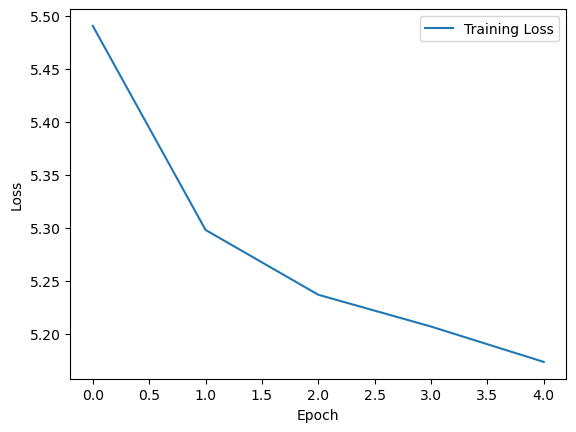

In [18]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

# Assuming you have already defined MyDataset and ModifiedResNet classes

# Define the training dataset and data loader
training_dataset = MyDataset(annotation_file="train_annos.json", data_dir="cars_train/")
train_loader = DataLoader(training_dataset, batch_size=8, shuffle=True)

# Define the model, optimizer, and loss function
model = ModifiedResNet(num_classes=196)
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss()

# Training loop parameters
num_epochs = 5
losses = []

# Training loop
for epoch in range(num_epochs):
    epoch_loss = 0.0
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as pbar:
        for images, labels in train_loader:
            optimizer.zero_grad()   
            outputs = model(images)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            pbar.update(1)
        
        losses.append(epoch_loss / len(train_loader))
        pbar.set_postfix({'Loss': losses[-1]})
        pbar.refresh()
        
        
    
    torch.save(model.state_dict(), "model_weights.pth") 

# Plot the loss over time
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Part D: Testing

One of the goals of deep learning is to make a model that generalizes to data it has never seen (e.g. new images of cars).  For this part, you will test your generalizability by running the model on a dataset it has not yet seen during training.  To do so, you will also need to put the model into  you will need to make sure you are not calculating any of the gradients by using `torch.no_grad` in a with statement. You will aslo need to put the network into evaluation mode:
```Python
model.eval()
with torch.no_grad():
    # enter testing code here
```

To put the network back into training mode, call `model.train()`.

You will compare your predictions with the ground truth value for value.  The output of your network, however, will be a vector of length 196 (the number of possible classes for the cars dataset) with the **largest** value representing the guessed class.  You'll need to extract the guessed class number and compare it with the ground truth number for all images in the test dataset and calculate the overall accuracy.  Print out the overall accuacy your model got.

While high test accuracy is not the only goal in this lab, most students are able to get above 50% in their testing accuracy. If you are unable to reach this level of accuracy, it may indicate an error in your code.

In [23]:
# model.eval()
# with torch.no_grad():
#     # enter testing code here

In [22]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

# Assuming you have already defined CarsDataset and ModifiedResNet classes

# Define the testing dataset and data loader
test_dataset = MyDataset(annotation_file="test_annos.json", data_dir="cars_test/")
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Initialize the model and load the trained weights
model = ModifiedResNet(num_classes=196)
model.load_state_dict(torch.load('model_weights.pth'))  

# Put the model in evaluation mode
model.eval()

# Testing loop
correct_predictions = 0
total_images = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get the index of the maximum value
        total_images += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

# Calculate and print the overall accuracy
accuracy = correct_predictions / total_images
print(f'Overall Accuracy on Test Set: {accuracy * 100:.2f}%')


100%|██████████████████████████████████████████████████████████████████████████████| 8041/8041 [07:44<00:00, 17.32it/s]

Overall Accuracy on Test Set: 0.87%


## Grading
Points for this assigment will be assigned as follows (100 points total):
* [30 pts] Making a Dataset class
* [10 pts] Setting up you architecture
* [30 pts] Training your model and plotting training loss
* [20 pts] Displaying the overall accuracy of your model

The last 10 points are earned through completing a subset of the following explorations:
* [10 pts] Increase the batch size of your training network. To do so, you will need to garauntee that all images in a batch are the same spatial resolution or it will not run. Thus, you will need to add random crop data augmentation, but make sure the crop is not too small, otherwise you might miss parts of the car. Describe the effects an increased batch_size had on training.
* [10 pts] Modify your code to include GPU acceleration using .cuda calls in the appropriate places. If you have an M1 or M2 processor Mac, you can modify your code to have MPS acceleration. Describe the speed-ups to the training loop after implementing acceleration.
* [10 pts] Enhance your dataloader to include reflection data augmentation (i.e. double the size of your training data by taking the mirror image across the y-axis). **DO NOT** do reflection augmentation across the x-axis (we don't care to detect cars when they are upside down!). You may also add other augmentations. Describe what effects the augmentation had on testing accuracy.
* [20 pts] Generate a confusion matrix of the 196 categories. A confusion matrix shows how often a specific category is guessed as each other category (you can search for example plots online). For example, the 11th row and 34th column in the matrix should tell you how many times category 11 images were guessed to be category 34 images. Thus, a perfect predictor on the test set would have nonzero values only along the diagnol. Once you generated the confusion matrix, you may simply plot it as a grayscale image (with interpolation turned off).
* [10 pts] Analyze the effect of learning rates on the accuracy of the network. Describe what you found and give supporting plots.
* [10 pts] Analyze the effect of epochs on the accuracy of the network. Describe what you found and give supporting plots.
* [10 pts] Analyze the effect of batch_size and varying optimizers on the accuracy of the network. Describe what you found and give supporting plots. 
* [10 pts] Analyze the effect of varying optimizers on the accuracy of the network. Describe what you found and give supporting plots. A list of optimizers in Pytorch can be found [here](https://pytorch.org/docs/stable/optim.html).
* [10 pts] Analyze the effect of different pretrained networks on the accuracy of the network. Describe what you found and give supporting plots. A list of pretrained networks in Pytorch can be found [here](https://pytorch.org/docs/stable/torchvision/models.html).

You may earn up to 20 points extra credit for additional explorations you complete.

An additional 15 points of extra credit will be given to the individual with the highest test accuracy.

Please describe which explorations you completed in the markdown cell below (or in the comments on Canvas)